In [16]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import seaborn as sns
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


The dispersion Parameter in revosim works that the smaller it is the bigger it is the displacement. In this code I'm first trying to calculate the max px displacement for a given set of sispersion paramenter and then I'll try to check what dispersion parameters I need to have a certain amount of displacement.

In [17]:
print(list(range(0, 256)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [18]:
d = [3, 4, 5, 6, 8, 10, 12, 15, 20, 25, 30, 35, 40, 50]
# d = list(range(1, 15))
b = list(range(0, 256))  # All integers from 0 to 255
a = list(range(361))  # All integers from 0 to 360 

#x = ( math.sqrt( ( 65536 ) / ( b + 1 ) ) - 16 ) * ( ( np.sin(a) ) / ( d ))


In [19]:
# empty list to store result of x
results = []

# loop over each combination of d, b, and a
for di in d:
    for bi in b:
        for ai in a:
            # find the value of x
            x = (math.sqrt((65536) / (bi + 1)) - 16) * (np.sin(np.radians(ai))/ di) 
            
            # Append the result to the list
            results.append([di, bi, ai, x])

# Create a DataFrame to store the results
df = pd.DataFrame(results, columns=['d', 'b', 'a', 'x'])

In [20]:
# empty list to store result of x
results = []

# loop over each combination of d, b, and a
for di in d:
    for bi in b:
        # find the value of x
        x = (math.sqrt((65536) / (bi + 1)) - 16) * (1/ di) 
        
        # Append the result to the list
        results.append([di, bi, x])

# Create a DataFrame to store the results
df = pd.DataFrame(results, columns=['d', 'b', 'x'])

In [21]:
# Group by 'd' and get the indices of max and min values of 'x'
max_x = df.groupby('d')['x'].idxmax()
min_x = df.groupby('d')['x'].idxmin()

# Get the rows corresponding to the max and min values of 'x' for each 'd'
max_x_rows = df.loc[max_x]
min_x_rows = df.loc[min_x]

# Add a column to identify if the row contains the max or min value
max_x_rows['type'] = 'max'
min_x_rows['type'] = 'min'

# Concatenate the DataFrames
max_min_x_rows = pd.concat([max_x_rows, min_x_rows])

In [22]:
# Save the max and min values to a single CSV file
max_min_x_rows.to_csv('dispersal-ranges.csv', index=False)

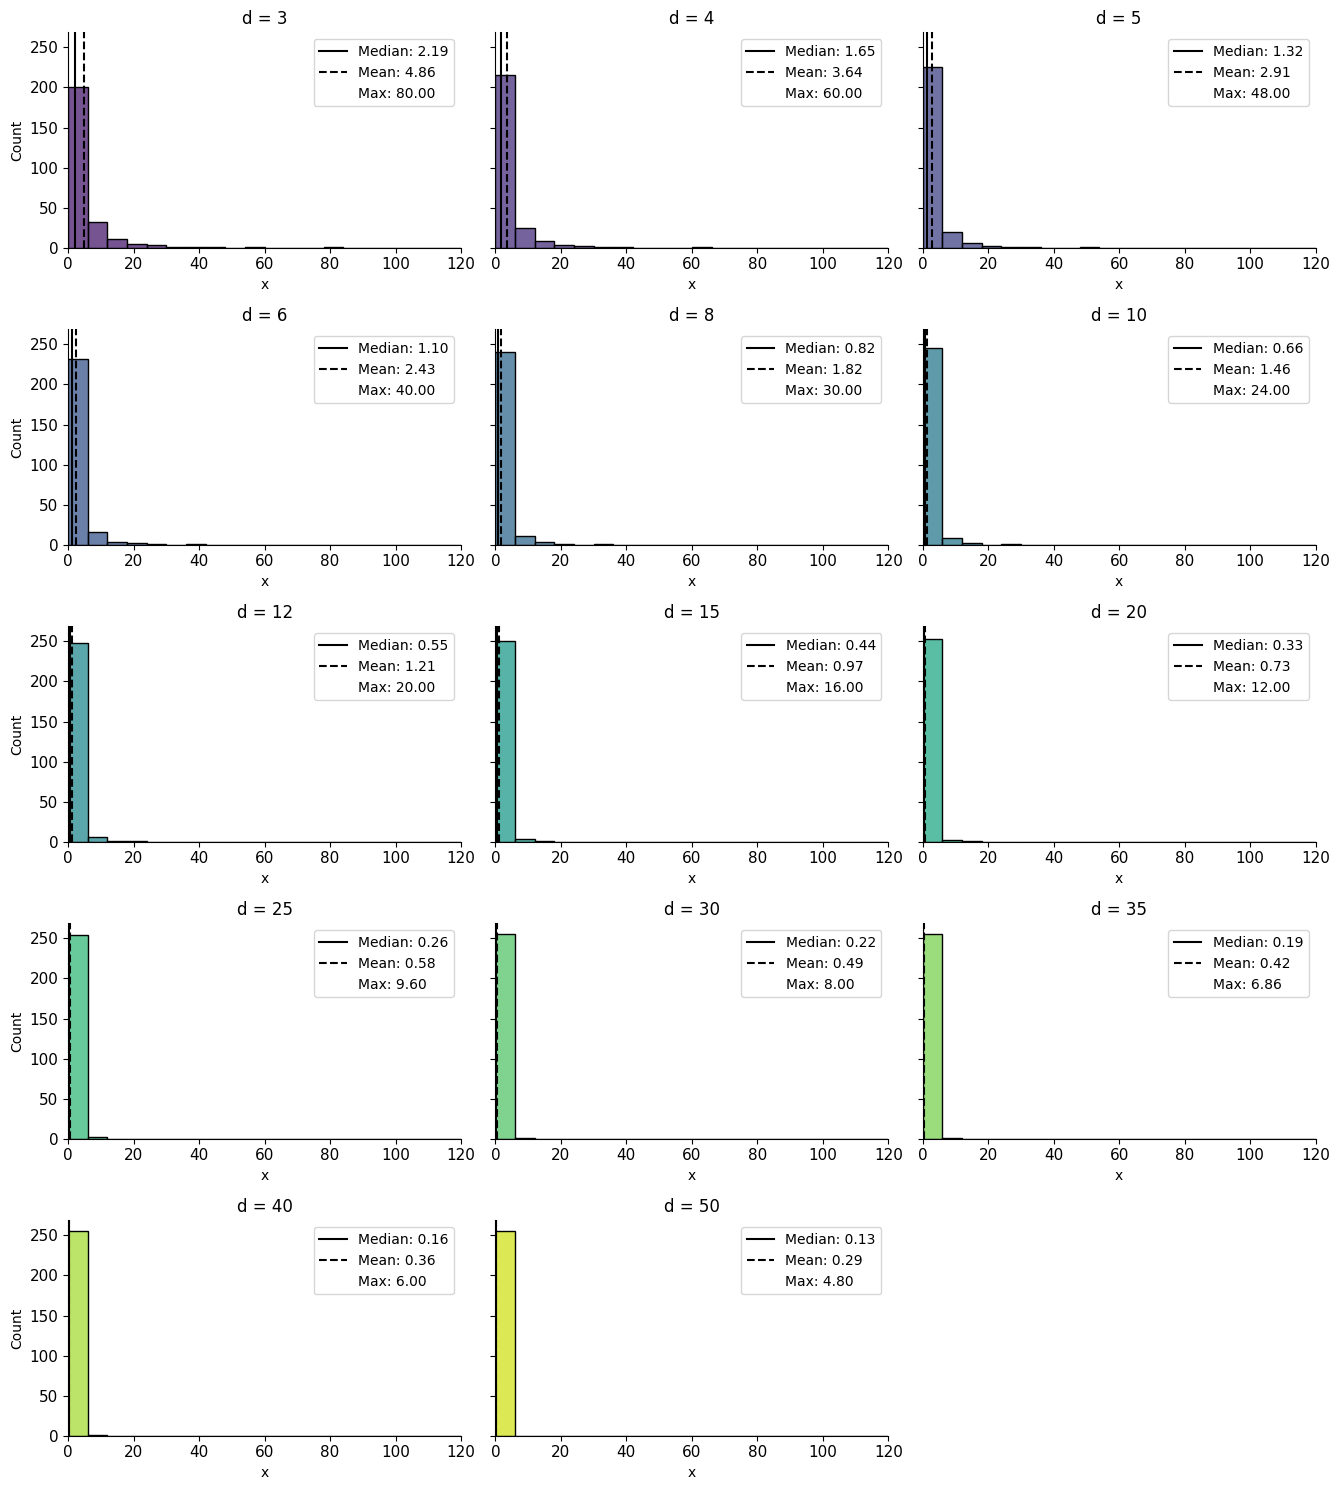

In [23]:
# Calculate x-axis limits for all histograms
x_min = df['x'].min()
x_max = 120

# Define the number of bins
num_bins = 20

# Create bin edges with equal width
bin_edges = [x_min + (x_max - x_min) * i / num_bins for i in range(num_bins + 1)]

# Create a FacetGrid with Seaborn and adjust canvas size
g = sns.FacetGrid(df, col="d", col_wrap=3, height=3, aspect=1.5, sharex=False)  # Adjust height as needed

# Iterate over unique categories and assign a different color from the Viridis palette to each histogram
for i, (disp, ax) in enumerate(zip(df["d"].unique(), g.axes.flat)):
    # Plot histogram
    sns.histplot(data=df[df['d'] == disp], x="x", bins=bin_edges, ax=ax, color=sns.color_palette("viridis", len(df["d"].unique()))[i])

    # Calculate median and mean
    median_val = df[df['d'] == disp]['x'].median()
    mean_val = df[df['d'] == disp]['x'].mean()
    max_val = df[df['d'] == disp]['x'].max()

    # Add vertical lines for median and mean
    ax.axvline(median_val, color='black', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(mean_val, color='black', linestyle='--', label=f'Mean: {mean_val:.2f}')
    ax.axvline(max_val, color='green', linestyle='--', alpha=0.0, label=f'Max: {max_val:.2f}')  # Set alpha to 0.5 for transparency

    

    # Set title
    ax.set_title(f'd = {disp}', fontsize=12)

    # Adjust tick label font size
    ax.tick_params(axis='both', which='major', labelsize=11)

    # Set legend
    ax.legend()

# Set x-axis limits for all histograms
g.set(xlim=(x_min, x_max))

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


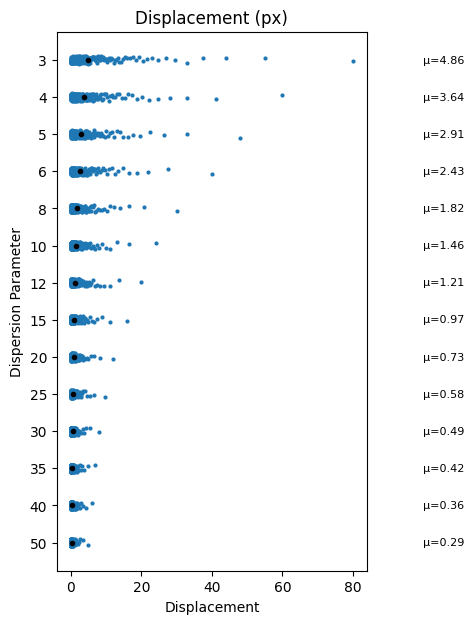

In [24]:
# Convert 'd' column to categorical data type
df['d'] = df['d'].astype('str')

fig, ax = plt.subplots(figsize=(4,7))
# Create strip plot
ax = sns.stripplot(data=df, x='x', y='d', jitter=True, size=3)

# Add mean points
disps = df['d'].unique()  # Get unique categories in sorted order

for i, disp in enumerate(disps):
    # Calculate median and mean
    median_val = df[df['d'] == disp]['x'].median()
    mean_val = df[df['d'] == disp]['x'].mean()
    ax.plot(mean_val, i, 'o', color = "black", markersize=3, zorder=3)  # Plot mean point

    # Annotate the mean value using the μ symbol
    ax.text(mean_val + (100-mean_val), i, f'μ={mean_val:.2f}', verticalalignment='center', horizontalalignment='left', fontsize=8, color='black')

# Add titles and labels
plt.title('Displacement (px)')
plt.xlabel('Displacement')
plt.ylabel('Dispersion Parameter')

# Show the plot
plt.show()

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3811046588.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df, x='x', y='d', palette='colorblind', alpha=0.7, cut=0, inner="quartile")


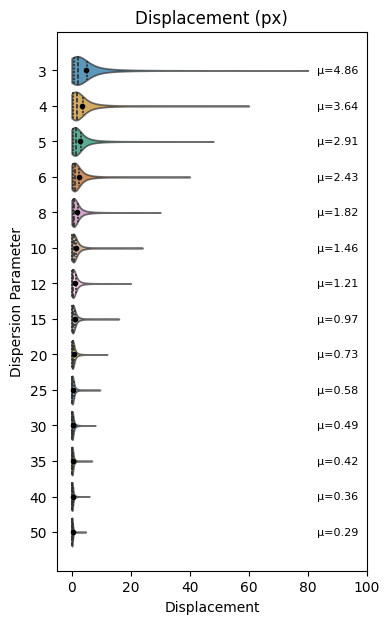

In [25]:

fig, ax = plt.subplots(figsize=(4,7))

# Create strip plot
ax = sns.violinplot(data=df, x='x', y='d', palette='colorblind', alpha=0.7, cut=0, inner="quartile")

# Add mean points
disps = df['d'].unique()  # Get unique categories in sorted order

for i, disp in enumerate(disps):
    # Calculate median and mean
    median_val = df[df['d'] == disp]['x'].median()
    mean_val = df[df['d'] == disp]['x'].mean()
    ax.plot(mean_val, i, 'o', color = "black", markersize=3, zorder=3)  # Plot mean point

    # Annotate the mean value using the μ symbol
    ax.text(mean_val + (83-mean_val), i, f'μ={mean_val:.2f}', verticalalignment='center', horizontalalignment='left', fontsize=8, color='black')

# Add titles and labels
plt.title('Displacement (px)')
plt.xlabel('Displacement')
plt.ylabel('Dispersion Parameter')
plt.xlim(-5, 100)

# Show the plot
plt.show()

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


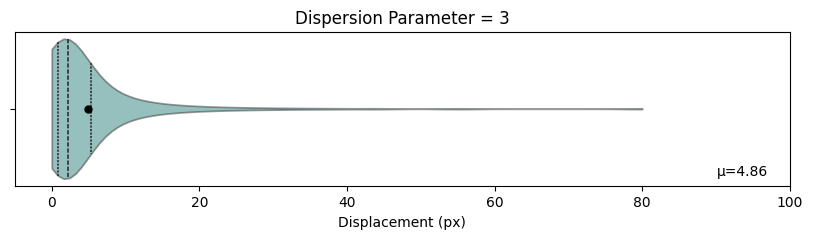

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


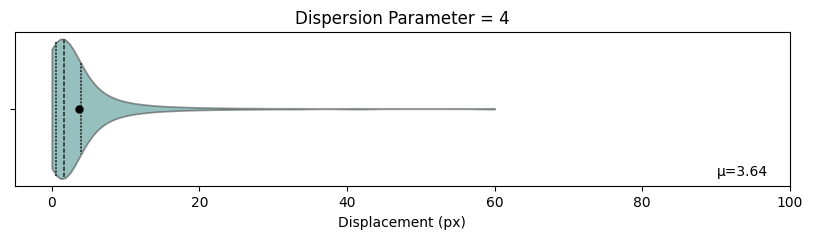

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


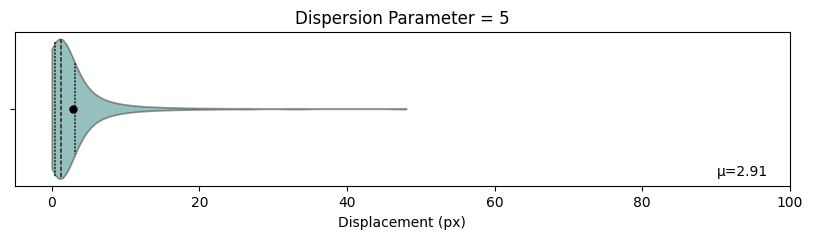

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


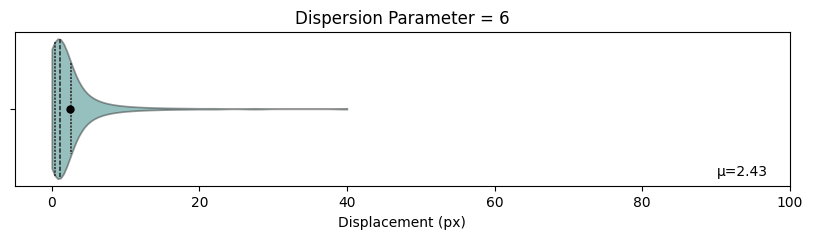

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


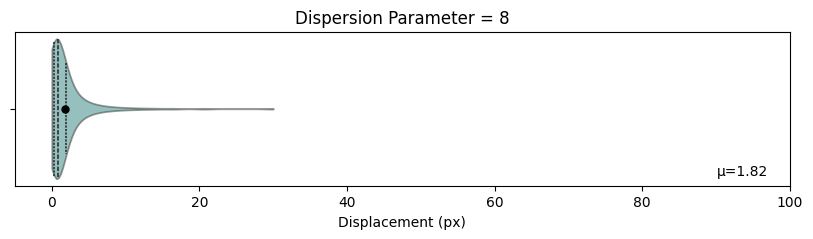

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


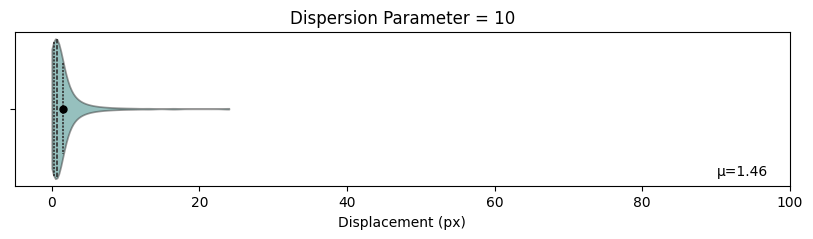

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


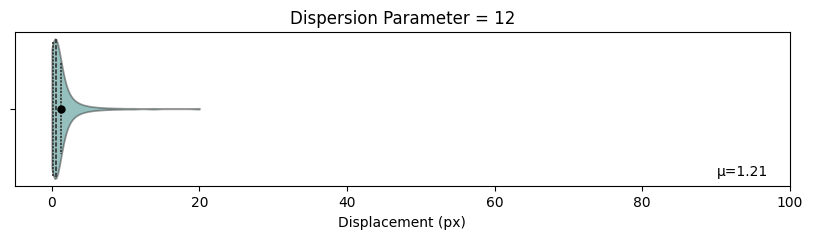

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


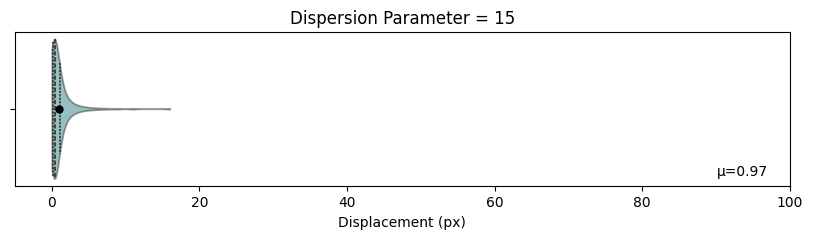

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


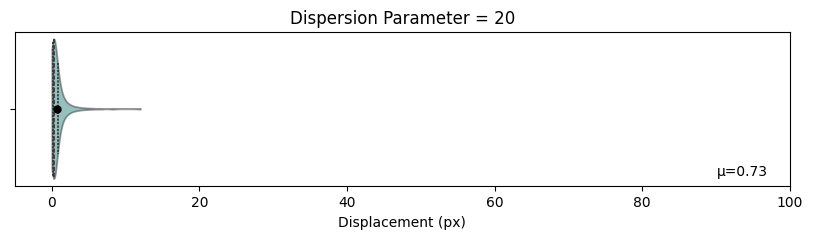

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


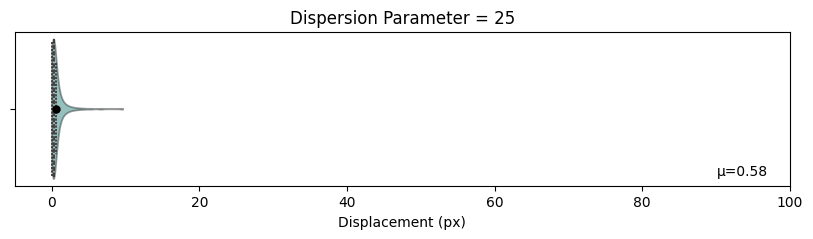

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


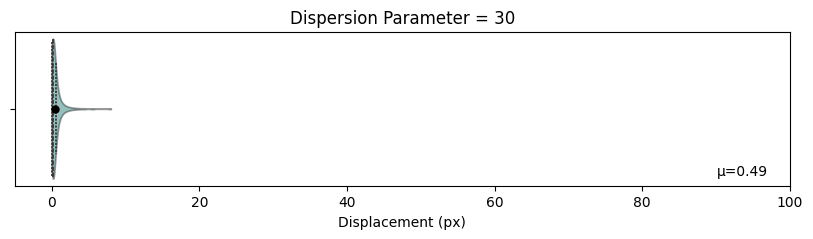

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


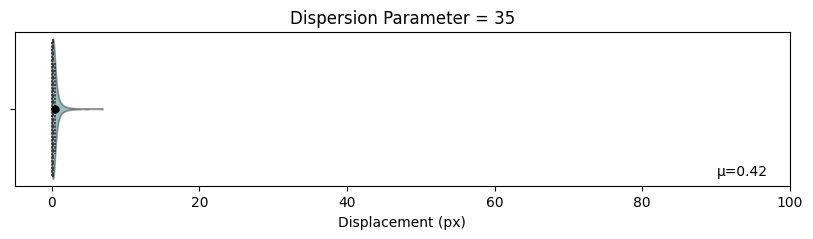

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


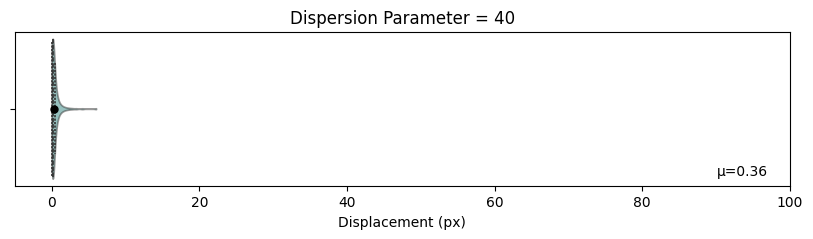

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_63657/3512780457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")


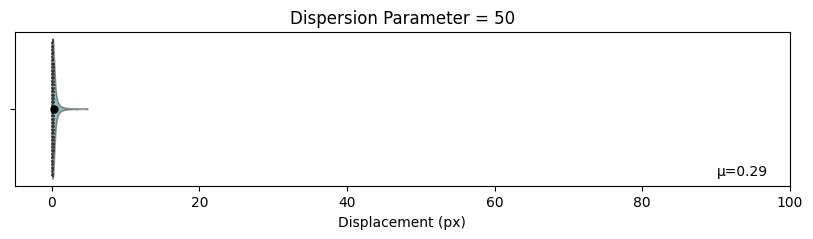

In [26]:
# Iterate over each unique category in 'd'
for disp in disps:
    # Create a new figure for each plot
    plt.figure(figsize=(10, 2))

    # Filter data for the current category
    data_subset = df[df['d'] == disp]

    # Create violin plot for the current category
    ax = sns.violinplot(data=data_subset, x='x', palette='viridis', alpha=0.5, cut=0, inner="quartile")

    # Calculate mean
    mean_val = data_subset['x'].mean()

    # Add mean point
    ax.plot(mean_val, 0, 'o', color="black", markersize=5, zorder=3)

    # Annotate the mean value using the μ symbol
    ax.text(97, 0.4, f'μ={mean_val:.2f}', verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

    # Add title and labels
    ax.set_title(f'Dispersion Parameter = {disp}')
    ax.set_xlabel('Displacement (px)')
    ax.set_ylabel('')
    ax.set_xlim(-5, 100)

    # Show the plot
    plt.show()

### Getting picts of environment and overlaying violinplots on top

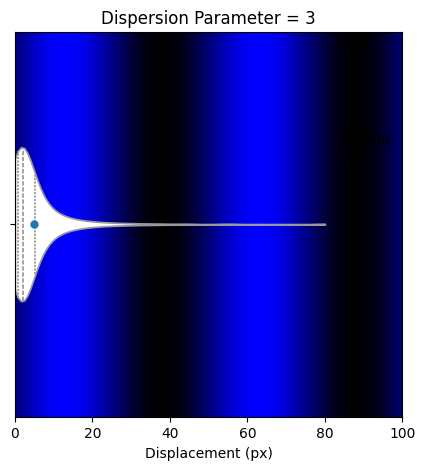

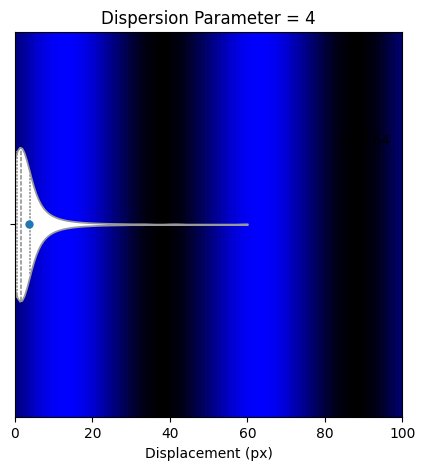

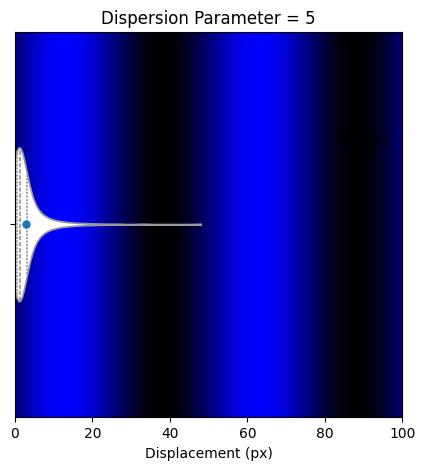

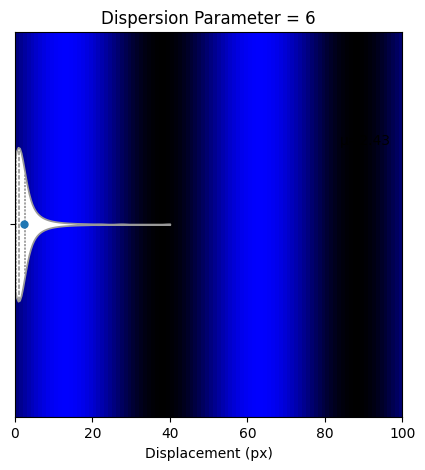

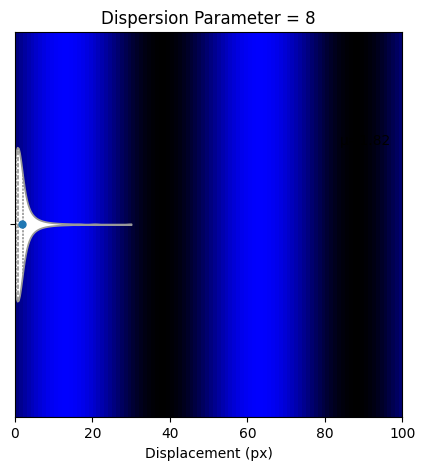

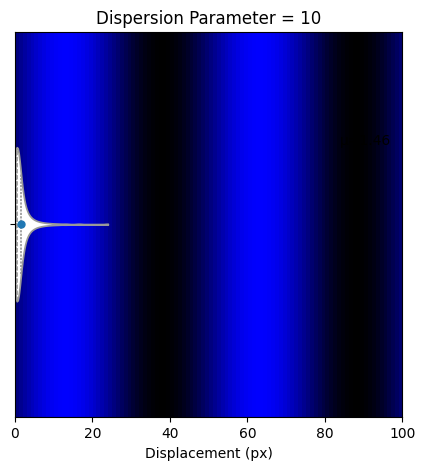

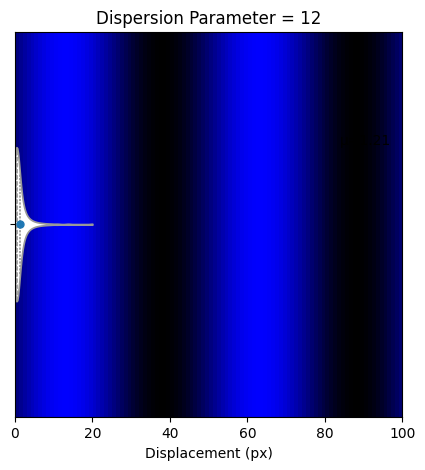

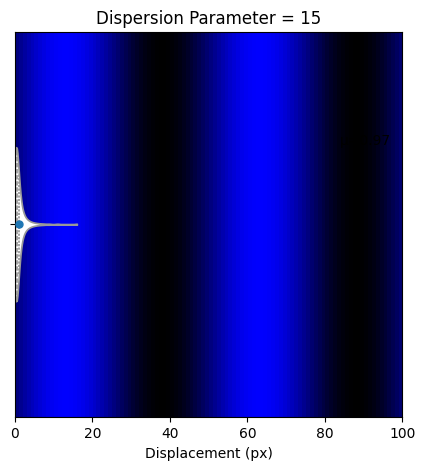

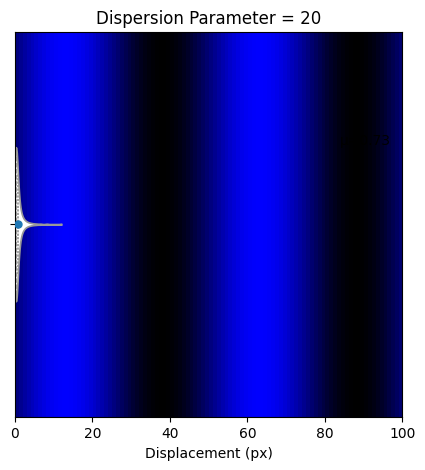

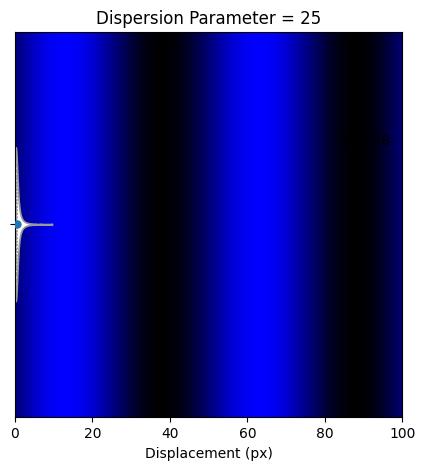

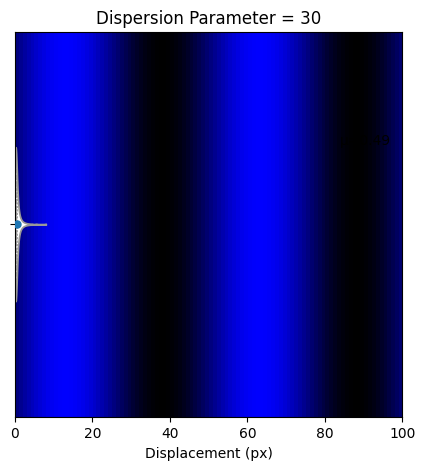

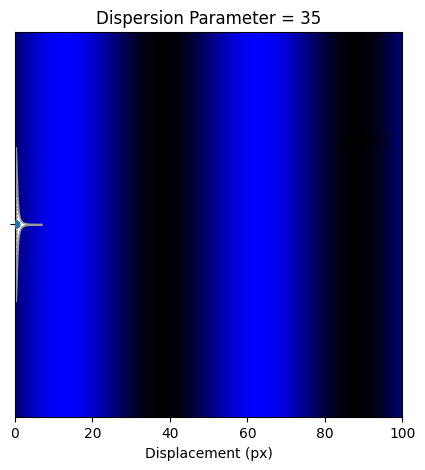

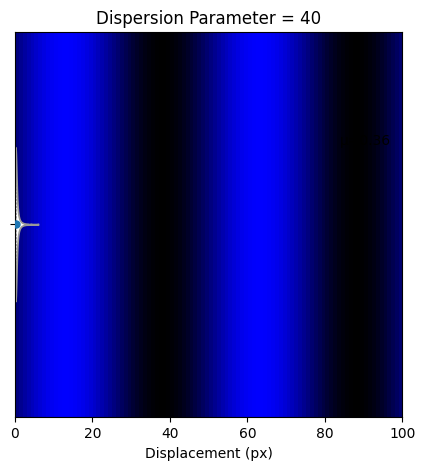

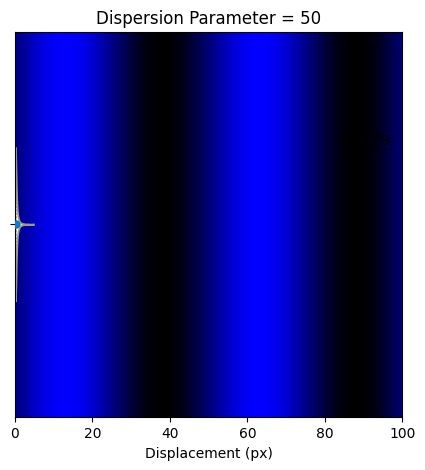

In [27]:
# Load the image
img = mpimg.imread('/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/environments/w50/w50_0RG.png')

# Get unique categories in 'd'
disps = df['d'].unique()

# Iterate over each unique category in 'd'
for disp in disps:
    # Create a new figure for each plot
    plt.figure(figsize=(5, 5))

    # Filter data for the current category
    data_subset = df[df['d'] == disp]

    # Create violin plot for the current category
    ax = sns.violinplot(data=data_subset, x='x', color = 'white', cut=0, inner="quartile")

    # Calculate mean
    mean_val = data_subset['x'].mean()

    # Add mean point
    ax.plot(mean_val, 0, 'o', markersize=5, zorder=3)

    # Annotate the mean value using the μ symbol
    ax.text(97, 0.4, f'μ={mean_val:.2f}', verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

    # Add title and labels
    ax.set_title(f'Dispersion Parameter = {disp}')
    ax.set_xlabel('Displacement (px)')
    ax.set_ylabel('')
    ax.set_xlim(0, 100)

    # Overlay the image
    plt.imshow(img, extent=[0, 100, -1, 1], aspect='auto', zorder=0)

    # Show the plot
    plt.show()


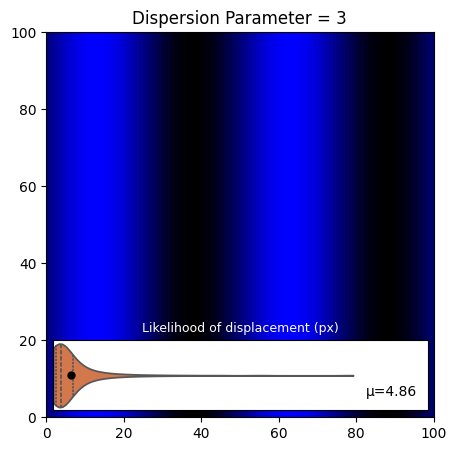

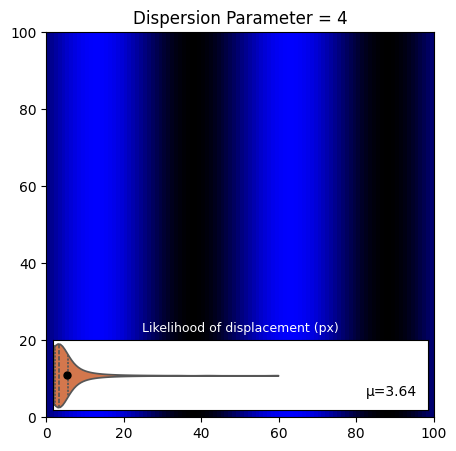

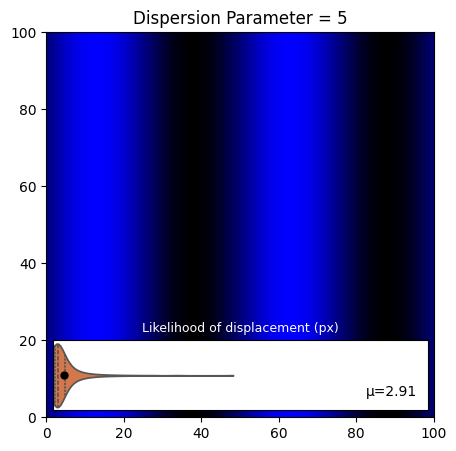

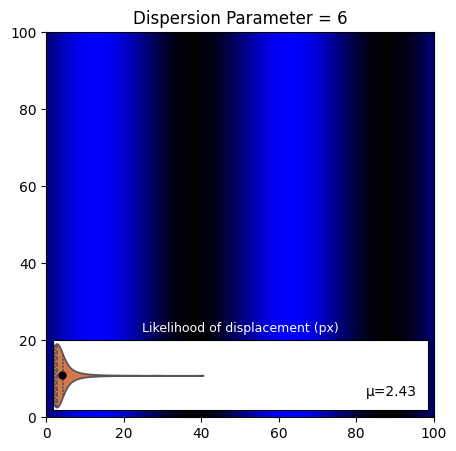

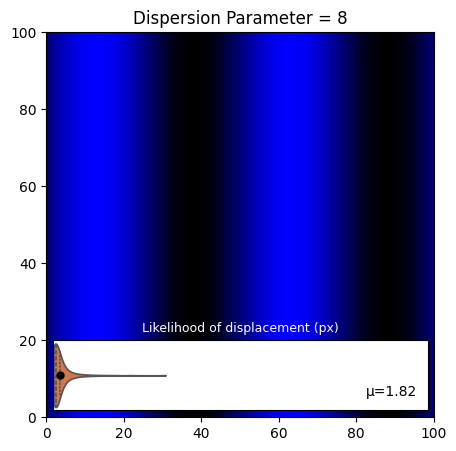

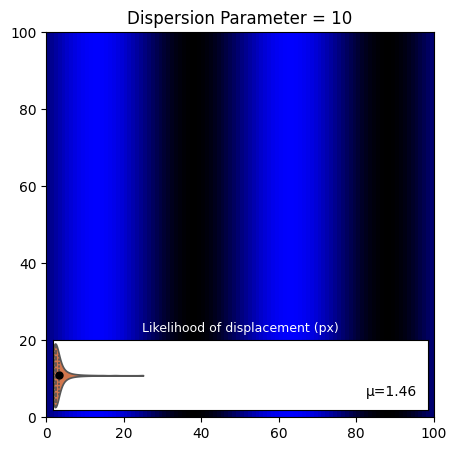

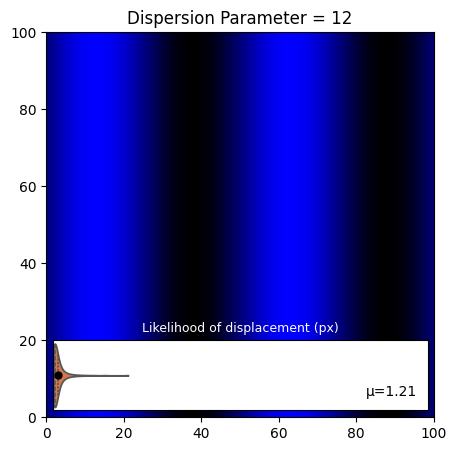

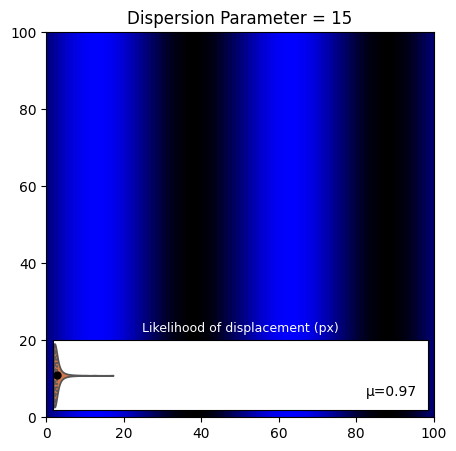

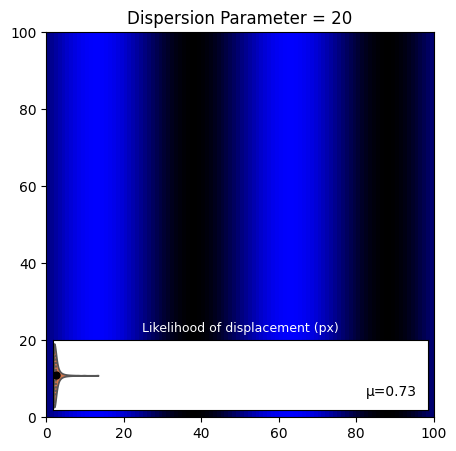

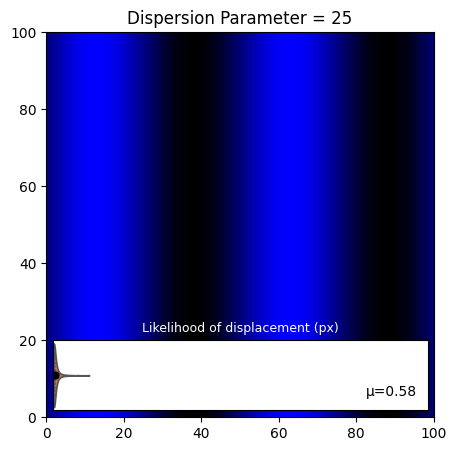

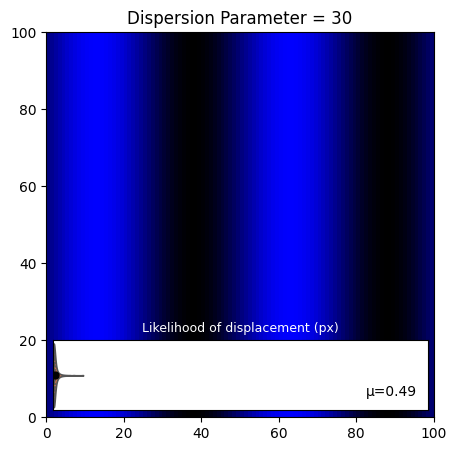

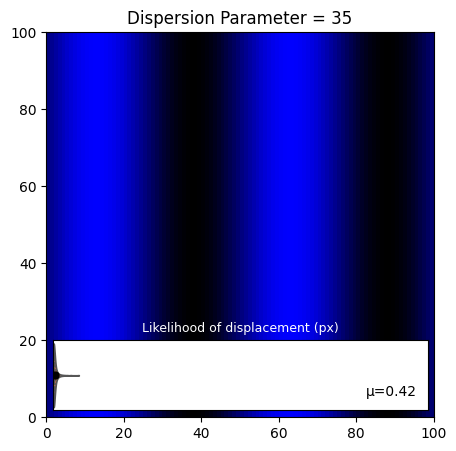

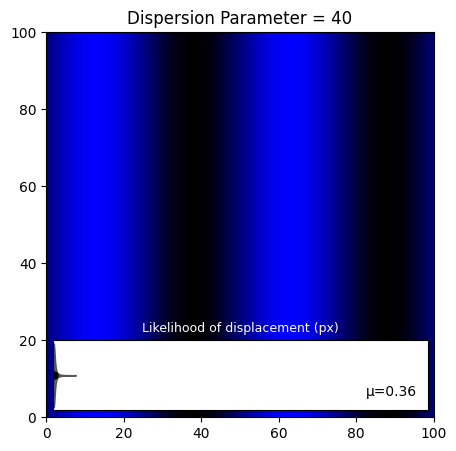

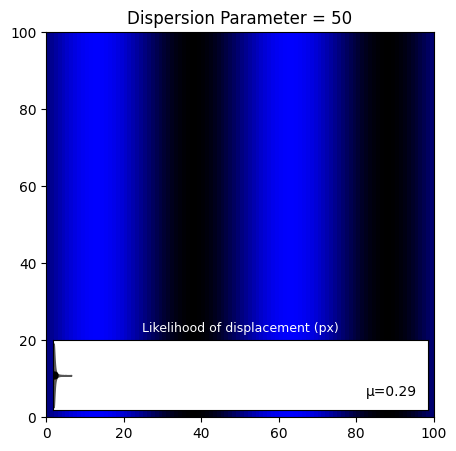

In [28]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Get unique categories in 'd'
disps = df['d'].unique()

# Iterate over each unique category in 'd'
for disp in disps:

    fig, ax= plt.subplots(figsize=(5, 5))

    # Set the axis limits for the main plot
    ax.axis([0, 100, 0, 100])
    # Show the image in the main plot
    ax.imshow(img, extent=[0, 100, 0, 100], aspect='auto')  # Adjust alpha as needed

    # # Create inset axes for the violin plot
    # inset_ax = inset_axes(ax,
    #                     width='96.5%',    # Adjust width as needed
    #                     height='20%',   # Adjust height as needed
    #                     loc='lower left')  # Adjust location as needed
    inset_ax = inset_axes(ax,
                            width=3.75,                     # inch
                            height=0.7,                    # inch
                            bbox_transform=ax.transAxes, # relative axes coordinates
                            bbox_to_anchor=(0,0),    # relative axes coordinates
                            loc=3)                       # loc=lower left corner                

    # Filter data for the current category
    data_subset = df[df['d'] == disp]


    # Create violin plot for the current category with gray filling
    sns.violinplot(data=data_subset, x='x', color = sns.color_palette('icefire')[5],  cut=0, inner="quartile", ax=inset_ax)

    # Calculate mean
    mean_val = data_subset['x'].mean()

    # Add mean point
    inset_ax.plot(mean_val, 0, 'o', color="black", markersize=5, zorder=3)

    # Annotate the mean value using the μ symbol
    inset_ax.text(97, 0.3, f'μ={mean_val:.2f}', verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

    # Add title and labels
    inset_ax.set_title('Likelihood of displacement (px)', color ='white', fontsize=9)
   
    # Remove x and y ticks
    inset_ax.set_xlim(0, 100)
    
    # Remove x and y ticks
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])

    # Remove x and y tick labels
    inset_ax.set_xticklabels([])
    inset_ax.set_yticklabels([])
    
    # Remove x labels
    inset_ax.set_xlabel('')
    
    # # Set background transparency
    # inset_ax.patch.set_alpha(0.7)
    
    # Add title
    ax.set_title(f'Dispersion Parameter = {disp}', fontsize=12)

    plt.show()

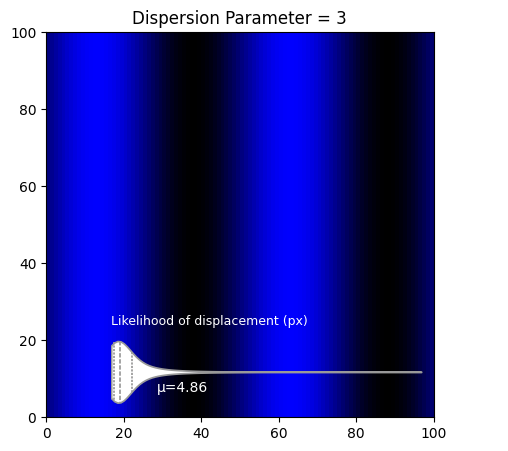

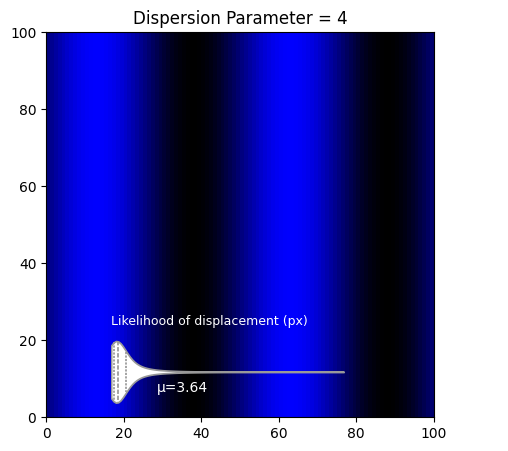

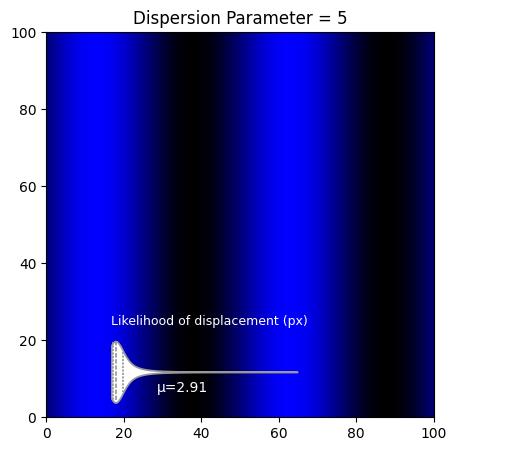

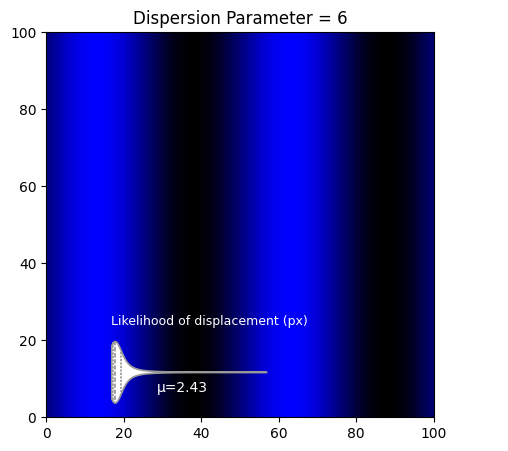

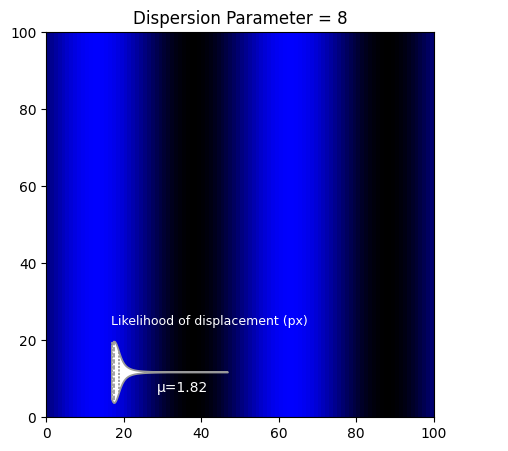

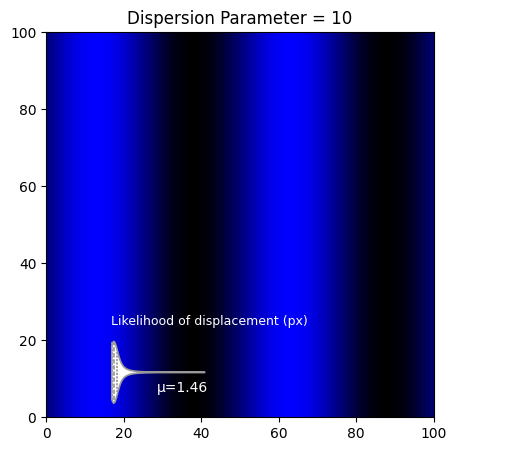

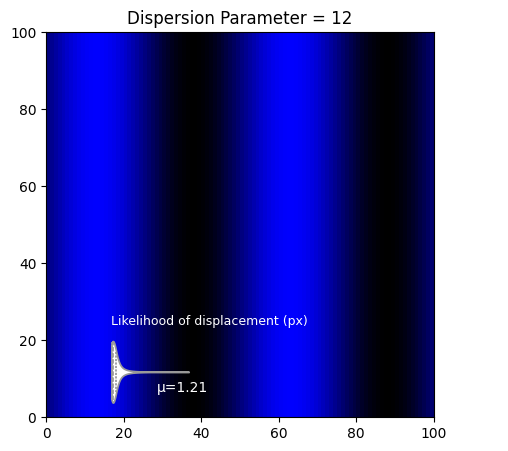

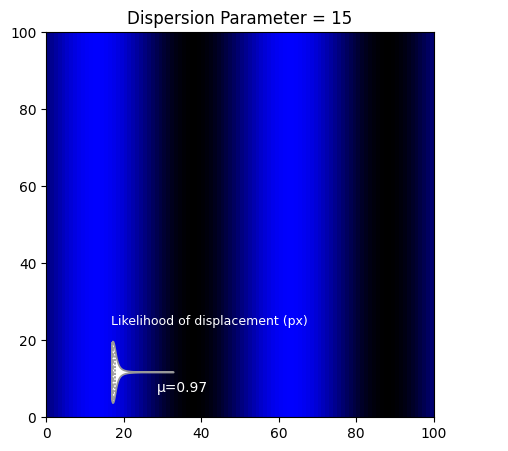

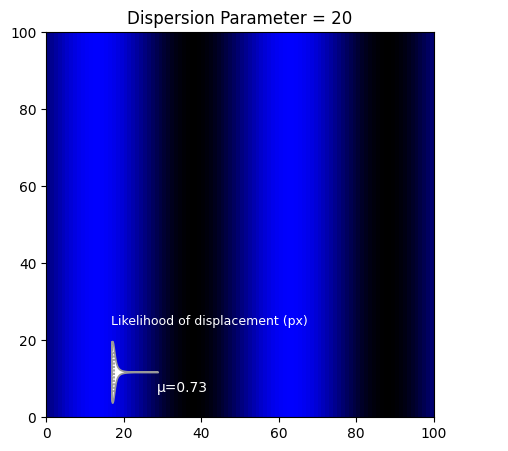

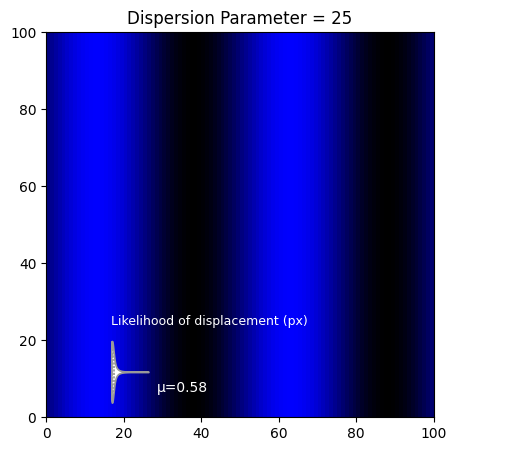

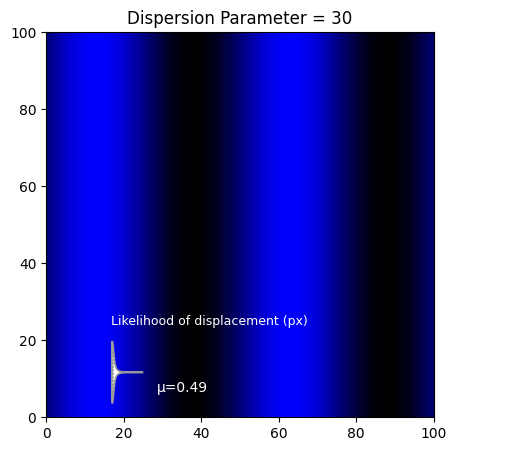

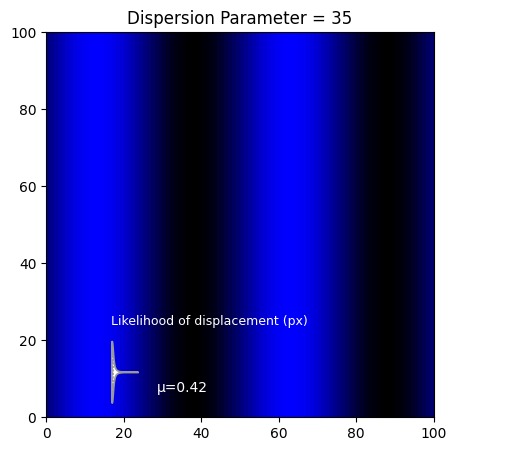

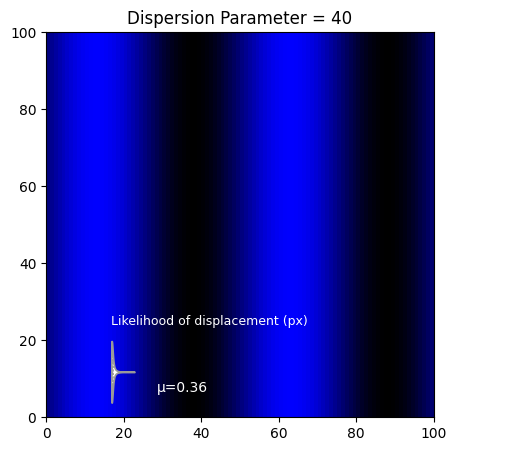

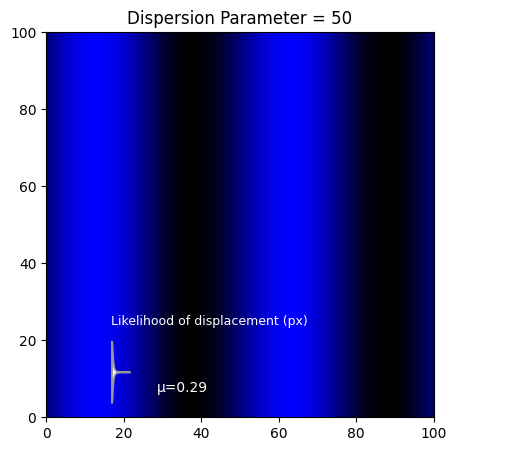

In [71]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Get unique categories in 'd'
disps = df['d'].unique()

# Iterate over each unique category in 'd'
for disp in disps:

    fig, ax= plt.subplots(figsize=(5, 5))

    # Set the axis limits for the main plot
    ax.axis([0, 100, 0, 100])
    # Show the image in the main plot
    ax.imshow(img, extent=[0, 100, 0, 100], aspect='auto') 

    # Create inset axes for the violin plot
    inset_ax = inset_axes(ax,
                        width='100%',    # Adjust width as needed
                        height='20%',   # Adjust height as needed
                        bbox_transform=ax.transAxes,  # Relative axes coordinates
                        bbox_to_anchor=(0.15, 0, 1, 1),      # Adjust the x-coordinate as needed
                        loc='lower left')  
    # inset_ax = inset_axes(ax,
    #                         width=3.865,                     # inch
    #                         height=0.7,                    # inch
    #                         bbox_transform=ax.transAxes, # relative axes coordinates
    #                         bbox_to_anchor=(-0.0155,0),    # relative axes coordinates
    #                         loc=3)                       # loc=lower left corner                

    # Filter data for the current category
    data_subset = df[df['d'] == disp]


    # Create violin plot for the current category with gray filling
    sns.violinplot(data=data_subset, x='x', color = 'white',  cut=0, inner="quartile", ax=inset_ax)

    # Calculate mean
    mean_val = data_subset['x'].mean()

    # Add mean point
    # inset_ax.plot(mean_val, 0, 'o', color="black", markersize=5, zorder=3)

    # Annotate the mean value using the μ symbol
    inset_ax.text(25, 0.3, f'μ={mean_val:.2f}', verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='white')

    # Add title and labels
    inset_ax.set_title('Likelihood of displacement (px)', color ='white', fontsize=9, loc='left')
   
    # Remove x and y ticks
    inset_ax.set_xlim(0, 100)
    
    # Remove x and y ticks
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])

    # Remove x and y tick labels
    inset_ax.set_xticklabels([])
    inset_ax.set_yticklabels([])
    
    # Remove x labels
    inset_ax.set_xlabel('')
    
    # Set background transparency
    inset_ax.patch.set_alpha(0.0)
    sns.despine(ax=inset_ax, top=True, right=True, bottom=True, left=True)
    
    # Add title
    ax.set_title(f'Dispersion Parameter = {disp}', fontsize=12)

    plt.show()

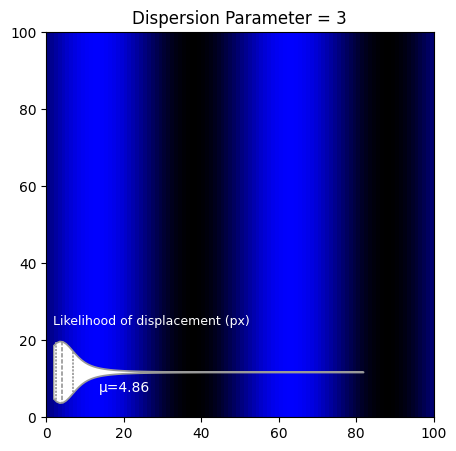

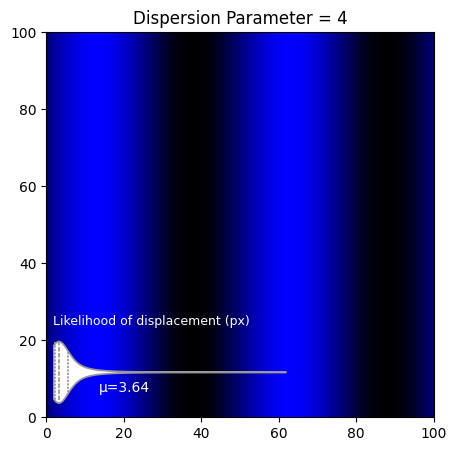

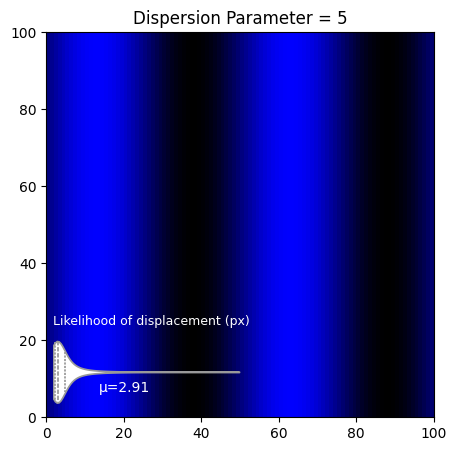

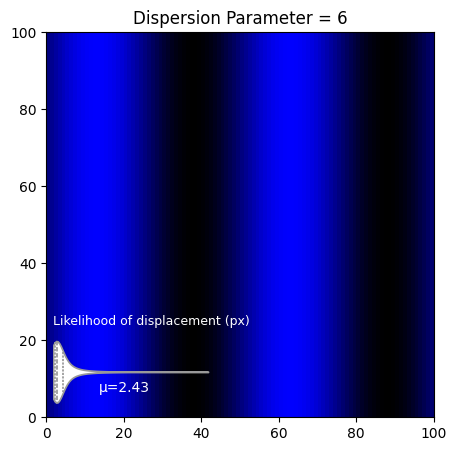

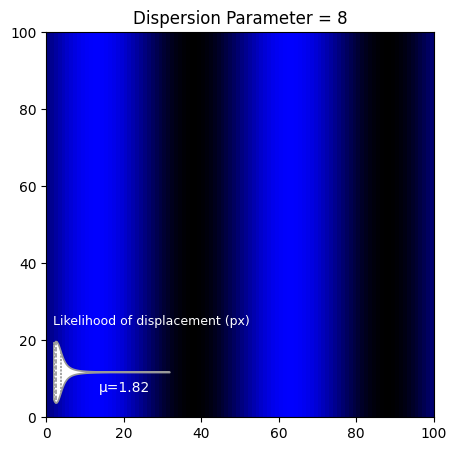

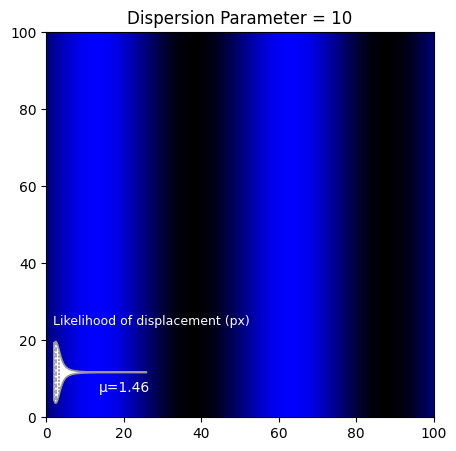

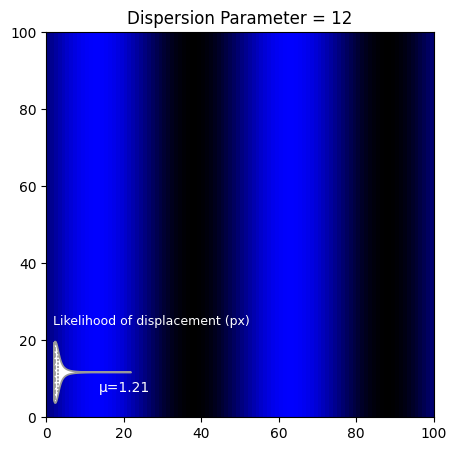

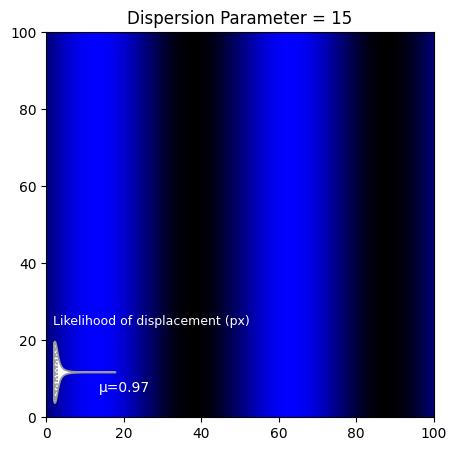

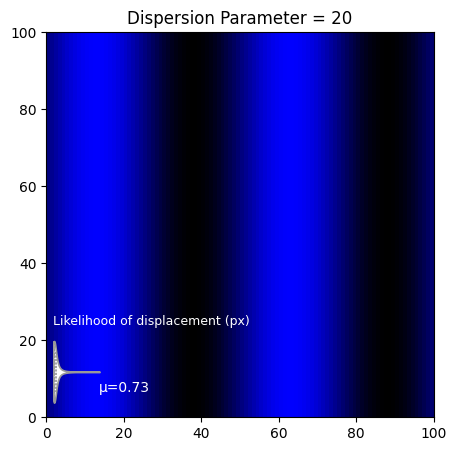

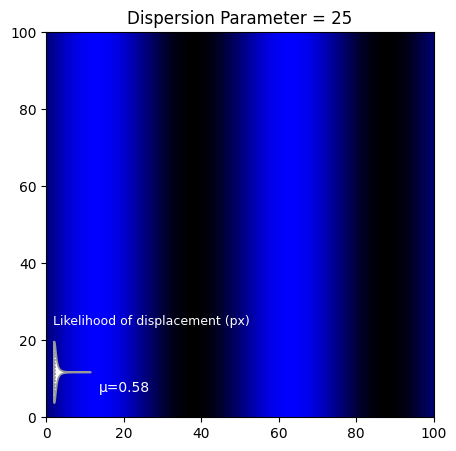

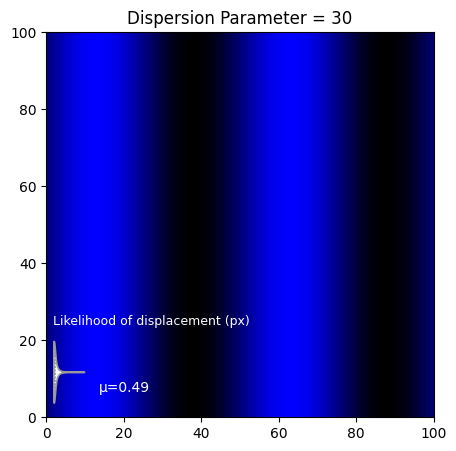

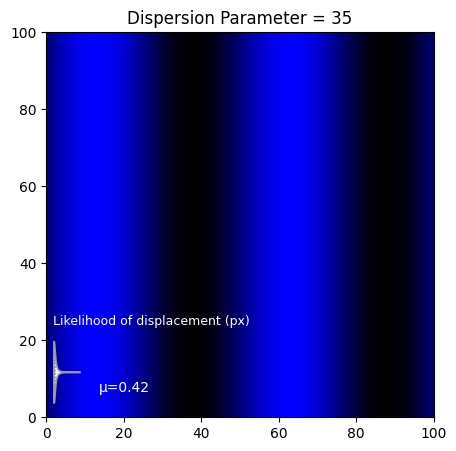

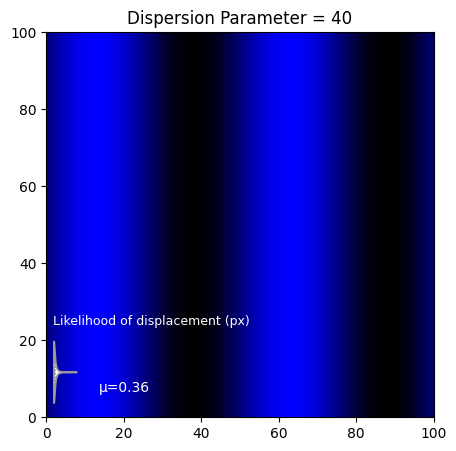

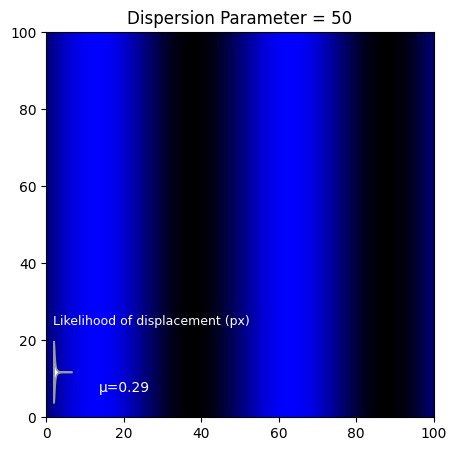

In [72]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Get unique categories in 'd'
disps = df['d'].unique()

# Iterate over each unique category in 'd'
for disp in disps:

    fig, ax= plt.subplots(figsize=(5, 5))

    # Set the axis limits for the main plot
    ax.axis([0, 100, 0, 100])
    # Show the image in the main plot
    ax.imshow(img, extent=[0, 100, 0, 100], aspect='auto') 

    # Create inset axes for the violin plot
    inset_ax = inset_axes(ax,
                        width='100%',    # Adjust width as needed
                        height='20%',   # Adjust height as needed
                        bbox_transform=ax.transAxes,  # Relative axes coordinates
                        bbox_to_anchor=(0, 0, 1, 1),      # Adjust the x-coordinate as needed
                        loc='lower left')  
    # inset_ax = inset_axes(ax,
    #                         width=3.865,                     # inch
    #                         height=0.7,                    # inch
    #                         bbox_transform=ax.transAxes, # relative axes coordinates
    #                         bbox_to_anchor=(-0.0155,0),    # relative axes coordinates
    #                         loc=3)                       # loc=lower left corner                

    # Filter data for the current category
    data_subset = df[df['d'] == disp]


    # Create violin plot for the current category with gray filling
    sns.violinplot(data=data_subset, x='x', color = 'white',  cut=0, inner="quartile", ax=inset_ax)

    # Calculate mean
    mean_val = data_subset['x'].mean()

    # Add mean point
    # inset_ax.plot(mean_val, 0, 'o', color="black", markersize=5, zorder=3)

    # Annotate the mean value using the μ symbol
    inset_ax.text(25, 0.3, f'μ={mean_val:.2f}', verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='white')

    # Add title and labels
    inset_ax.set_title('Likelihood of displacement (px)', color ='white', fontsize=9, loc='left')
   
    # Remove x and y ticks
    inset_ax.set_xlim(0, 100)
    
    # Remove x and y ticks
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])

    # Remove x and y tick labels
    inset_ax.set_xticklabels([])
    inset_ax.set_yticklabels([])
    
    # Remove x labels
    inset_ax.set_xlabel('')
    
    # Set background transparency
    inset_ax.patch.set_alpha(0.0)
    sns.despine(ax=inset_ax, top=True, right=True, bottom=True, left=True)
    
    # Add title
    ax.set_title(f'Dispersion Parameter = {disp}', fontsize=12)

    plt.show()